### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 2048
blocklen = (blocklenk * 1024)

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 1,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

This generation of ld-decode uses FFT multiplication to perform convolutions. This allows multiple filter types to be "stacked" into a minimal number of general operations.

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'))
    SP['Fvideo_lpf05'] = filtfft(sps.butter(SP['vlpf_order'], 0.5/freq_hz_half, 'low'))

    # post-demod deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp']
    SP['FVideo05'] = SP['Fvideo_lpf05'] * SP['Fdeemp']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [11]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data1)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    tdangles2[tdangles2 < 0] += tau
    tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    output = np.fft.ifft(demod_fft * paramsc['FVideo']).real

    return output

In [12]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [13]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [14]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [61]:
# nice GGV sample (40msps)
#infile = open('ggv1069_22000.raw', 'rb')

# discovision logo (rotted :P )
#infile = infile = open('/home/cpage/erica_44a.raw', 'rb')
#infile.seek(1024 * 1024 * 1400)

infile = infile = open('ggv_14401.raw', 'rb')
#infile.seek(1024 * 1024)
#infile = infile = open('/home/cpage/ve22_44zonea.raw', 'rb')

inbuf = infile.read(1024 * 1024 * 8)
indata1 = np.fromstring(inbuf, 'int16', len(inbuf) // 2)

data1 = indata1[400000:400000+blocklen]
#data2 = indata1[blocklen:blocklen*2]


In [62]:
blockcut = 1024

params['freq'] = 40.0
params['deemp'] = (120*.65, 320*.65)
filterset = prepare_video_filters(params)

output = dodemod(filterset, data1, usemtf=False)


In [63]:
output

array([ 8187006.35299863,  8156328.33216157,  8047460.57123863, ...,
        8195739.3402814 ,  8190747.49508365,  8189296.6842989 ])

Below this is the less developed code to deal with NTSC framing and syncs.

In [64]:
# NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks

output_sync = (output > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (output < (params['videorf_0ire'] + (params['hz_ire'] * -25)))

# Perform FFT convolution of above filter
output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

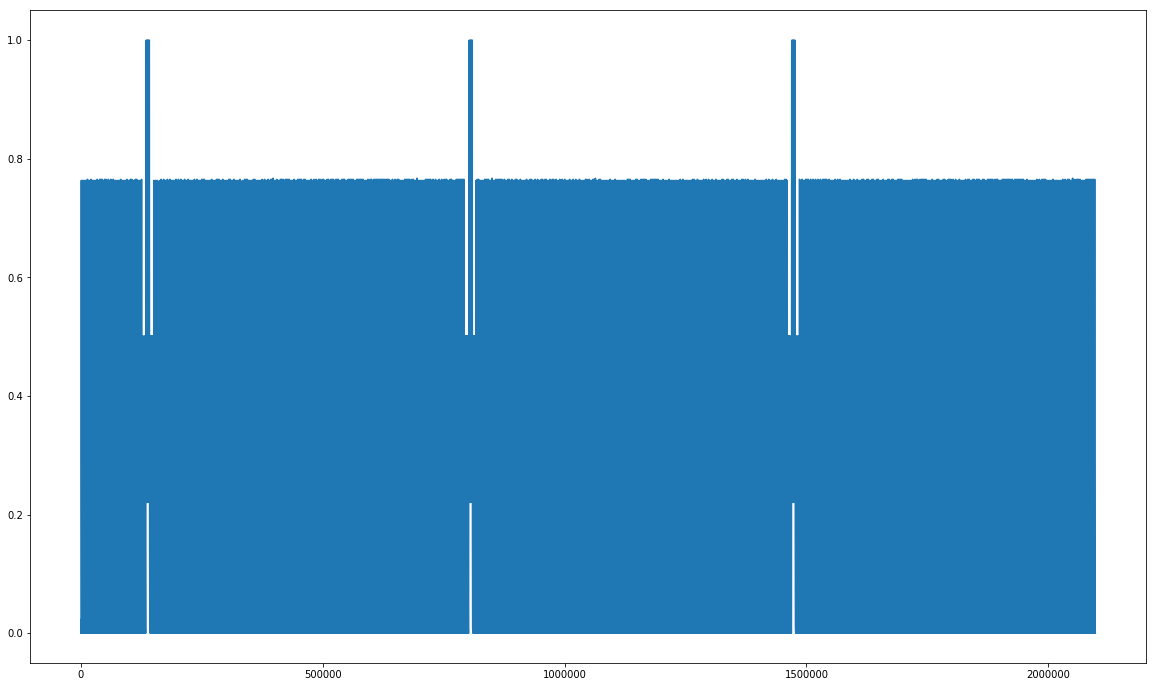

In [65]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_syncf)

In [66]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 400000
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_syncf):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_syncf[loc:loc+imglen]) + loc

if np.max(output_syncf[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

809108

In [67]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_syncf, syncloc)

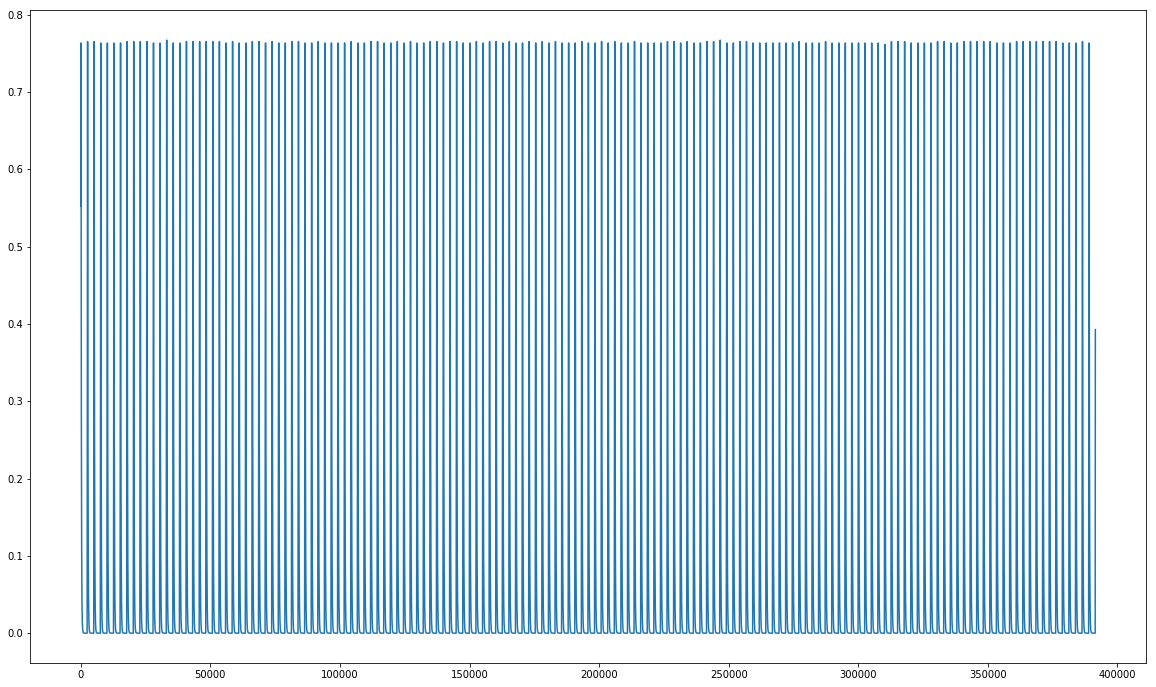

In [68]:
plt.plot(output_syncf[nextline:syncloc+399430])

In [69]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [70]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_syncf[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_syncf[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

819657 7746581.21259 8105734.80864
822200 7759037.57216 8089092.82529
824743 7738165.16658 8078094.84994
827286 7740171.74255 8118842.59404
829829 7747010.09646 8110683.13538
832372 7743762.65436 8098334.73172
834916 7759917.32646 8111587.11446
837459 7761847.83052 8119201.68688
840002 7769096.2486 8111610.05891
842545 7763396.59429 8102181.31461
845088 7758245.27124 8106724.08976
847631 7761996.05242 8096280.56188
850175 7794184.83352 8095856.03781
852717 7741017.71902 8093410.19606
855260 7727263.60778 8103025.09821
857804 7781827.01634 8106314.53951
860347 7795955.05424 8114827.1769
862890 7792497.95199 8100934.28161
865433 7786889.13008 8102360.15188
867976 7770044.94397 8116812.49713
870519 7787845.05212 8116952.55538
873061 7729202.82089 8097177.98821
875605 7779267.26226 8098017.77637
878147 7756494.61448 8110023.87874
880690 7748031.04778 8108831.29536
883233 7756665.65374 8101280.19656
885776 7792287.54807 8090528.74803
888318 7734513.85963 8106949.98238
890862 7780355.60027 8

In [71]:
m20ire = 8100000-hz_ire_scale*20

In [72]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [73]:
video_05 = filtfft(sps.butter(3, 0.5/22, 'low'))
output_lp = np.fft.ifft(np.fft.fft(output) * video_05).real[29:] 

In [74]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


819657 7746581.21259 7812957.86107 7890325.56696
822200 7759037.57216 7826627.76378 7896987.30568
824743 7738165.16658 7809492.1086 7891012.82842
827286 7740171.74255 7797857.45584 7863953.89741
829829 7747010.09646 7798765.20358 7854994.59244
832372 7743762.65436 7797853.68922 7854640.50386
834916 7759917.32646 7834896.58077 7913945.45408
837459 7761847.83052 7822273.45831 7891924.89233
840002 7769096.2486 7837942.8614 7905862.66665
842545 7763396.59429 7820880.41423 7886196.2164
845088 7758245.27124 7832255.30988 7905133.94502
847631 7761996.05242 7827315.96416 7896112.89557
850175 7794184.83352 7880660.55649 7966480.5776
852717 7741017.71902 7806373.67479 7882638.32127
855260 7727263.60778 7801389.62174 7877809.92681
857804 7781827.01634 7844828.20661 7916508.32345
860347 7795955.05424 7856976.34299 7917672.41782
862890 7792497.95199 7863632.35113 7934371.07197
865433 7786889.13008 7857050.78539 7928209.87744
867976 7770044.94397 7837570.71302 7913422.86586
870519 7787845.05212 7852

In [75]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output_lp, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


819657 817033 817033 7746581.21259 7812957.86107 7890325.56696
822200 819659.542275 822015.497942 7759037.57216 7826627.76378 7896987.30568
824743 822202.693624 824558.564279 7738165.16658 7809492.1086 7891012.82842
827286 824746.031224 827102.6185 7740171.74255 7797857.45584 7863953.89741
829829 827289.020526 829644.788542 7747010.09646 7798765.20358 7854994.59244
832372 829832.289725 832187.888596 7743762.65436 7797853.68922 7854640.50386
834916 832375.42052 834731.007343 7759917.32646 7834896.58077 7913945.45408
837459 834918.411396 837274.092176 7761847.83052 7822273.45831 7891924.89233
840002 837461.551407 839817.146551 7769096.2486 7837942.8614 7905862.66665
842545 840004.710158 842360.093791 7763396.59429 7820880.41423 7886196.2164
845088 842547.762808 844903.204041 7758245.27124 7832255.30988 7905133.94502
847631 845090.969606 847446.422059 7761996.05242 7827315.96416 7896112.89557
850175 847633.791275 849989.466456 7794184.83352 7880660.55649 7966480.5776
852717 850176.886221 

In [76]:
# experiment:  filter color burst data for easier alignment

In [77]:
video_cburst = filtfft(sps.butter(2, [(300/88.0)/22, (330/88.0)/22], 'bandpass'))


In [78]:
output_cburst = np.fft.ifft(np.fft.fft(output - 8100000) * video_cburst).real[98:] + 8100000

In [79]:
calczc(output_lp, int(lineinfo2[250])-80, m20ire, 200), calczc(output, int(lineinfo2[250])-80, m20ire, 200)

(1452643.2171929996, 1452642.482662265)

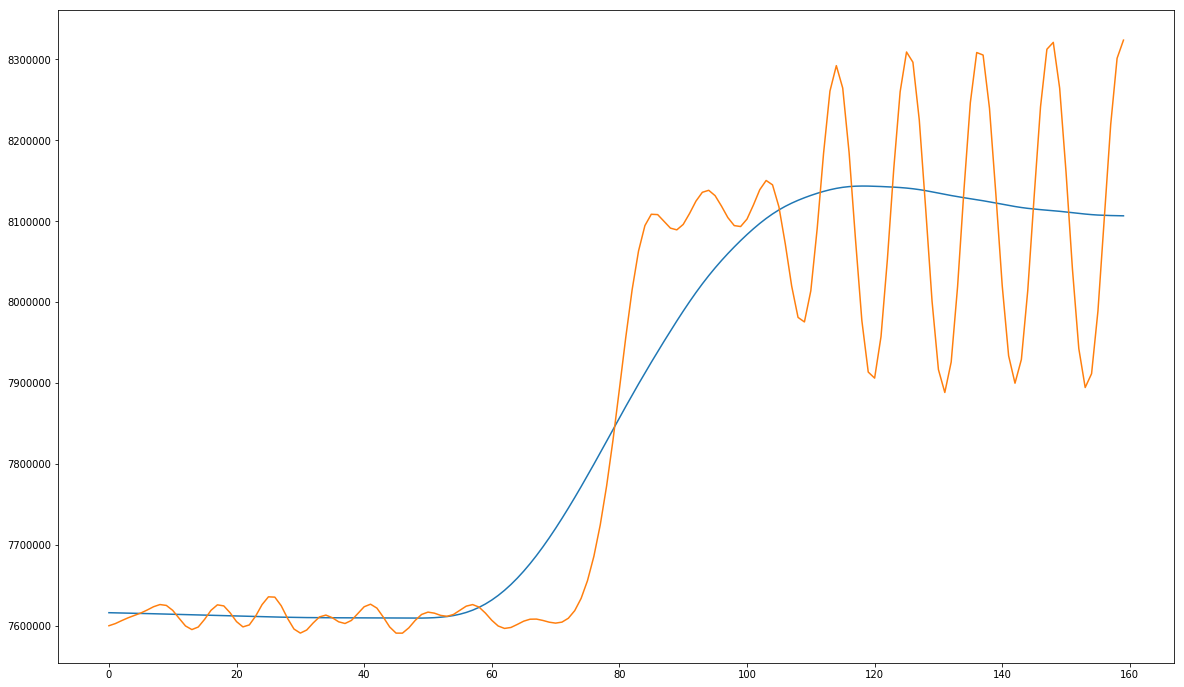

In [80]:
plt.plot(output_lp[int(lineinfo2[250]-80):int(lineinfo2[250])+80])
plt.plot(output[int(lineinfo2[250])-80:int(lineinfo2[250])+80])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

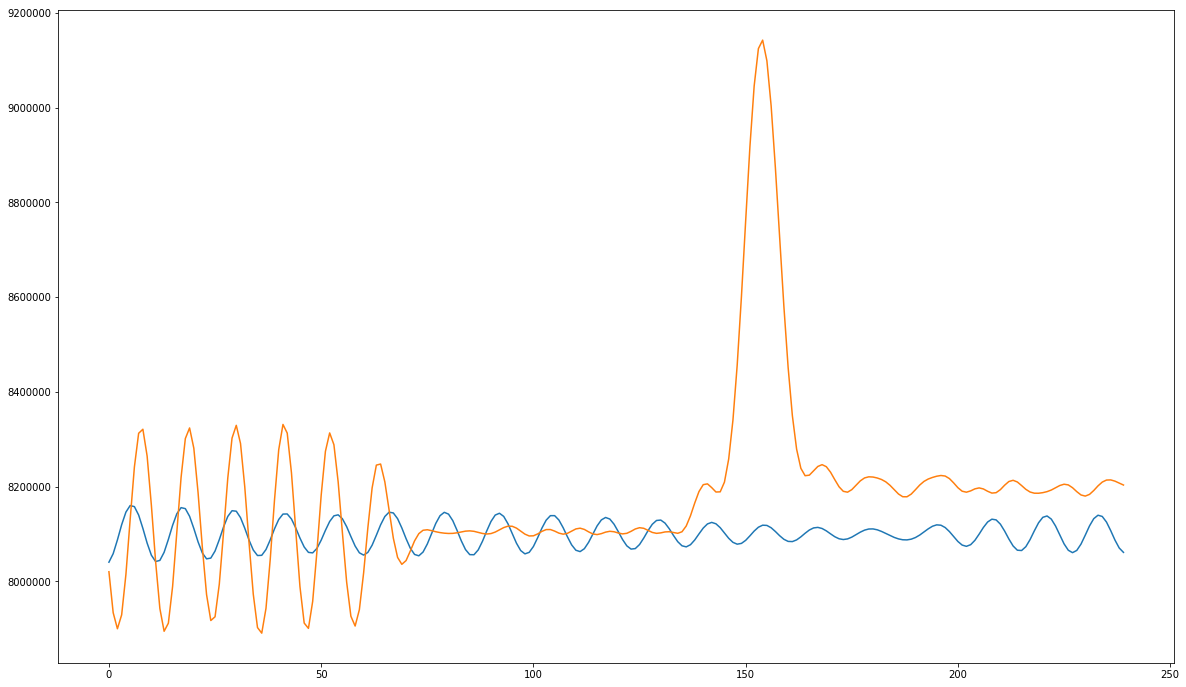

In [81]:
plt.plot(output_cburst[int(lineinfo2[250]+60):int(lineinfo2[250])+300])
plt.plot(output[int(lineinfo2[250])+60:int(lineinfo2[250])+300])
#plt.plot(output[int(lineinfo2[50]):int(lineinfo2[51])])

In [82]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output_lp, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


819657 7746581.21259 7812957.86107 7890325.56696
822200 7759037.57216 7826627.76378 7896987.30568
824743 7738165.16658 7809492.1086 7891012.82842
827286 7740171.74255 7797857.45584 7863953.89741
829829 7747010.09646 7798765.20358 7854994.59244
832372 7743762.65436 7797853.68922 7854640.50386
834916 7759917.32646 7834896.58077 7913945.45408
837459 7761847.83052 7822273.45831 7891924.89233
840002 7769096.2486 7837942.8614 7905862.66665
842545 7763396.59429 7820880.41423 7886196.2164
845088 7758245.27124 7832255.30988 7905133.94502
847631 7761996.05242 7827315.96416 7896112.89557
850175 7794184.83352 7880660.55649 7966480.5776
852717 7741017.71902 7806373.67479 7882638.32127
855260 7727263.60778 7801389.62174 7877809.92681
857804 7781827.01634 7844828.20661 7916508.32345
860347 7795955.05424 7856976.34299 7917672.41782
862890 7792497.95199 7863632.35113 7934371.07197
865433 7786889.13008 7857050.78539 7928209.87744
867976 7770044.94397 7837570.71302 7913422.86586
870519 7787845.05212 7852

In [83]:
# now to get fine sync!

In [84]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [85]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [86]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [87]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [88]:
def calcerr(line):
    subset = line[5:60]
    
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [89]:
910 * 1.2

1092.0

In [90]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
finalsnr = []

# because of odd issues, it makes sense to do one line and the next burst together, and so on...
for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

        offset1 = calcerr(scaled[0:60])
        offset2 = calcerr(scaled[910:970])
        print(l, i, offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if (i == 0):
            lineinfo_tmp[l + 1] += ((offset2 - offset1) * (linelen / 910) * (0.83 / (i + 1)))
        else:
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * (.4 / (i + 1)))
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * (.4 / (i + 1)))
            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 0.0293432838011 0.0139157740528 40.8677731789
1 1 0.0298714696357 0.0332982899955 40.8999437702
1 2 0.0216994789467 0.0235207707683 40.9026942816
1 3 0.0177338044244 0.0188919924055 40.9037174903
1 4 0.0153003515767 0.0161010541026 40.9042589228
1 f 0.0136194780282 0.0141979673997 40.9045969374
2 0 0.01065384529 -0.0574023894554 39.7410916081
2 1 0.0132148334631 0.0239019218904 40.8170883501
2 2 0.00922517975826 0.0171743188696 40.8186526824
2 3 0.00737568473082 0.0139228102707 40.8180298925
2 4 0.00626617631224 0.0119434068944 40.8171824989
2 f 0.00551183192187 0.0105804812932 40.8163871652
3 0 0.0116662424713 -0.0417928697646 40.9033351363
3 1 0.0135700950546 0.0248605610865 41.2150685279
3 2 0.00966161491712 0.017678574733 41.2423087431
3 3 0.00780104771717 0.0142557717938 41.2536237721
3 4 0.00667440340202 0.0121695406182 41.2599597637
3 f 0.00590333581819 0.0107310365805 41.2640599642
4 0 0.00493340236171 -0.0834676754864 39.3012334918
4 1 0.00827189913207 0.0218193195816 41.0

43 4 0.000731289380699 -0.00127349983334 42.2187420884
43 f 0.000653415057869 -0.00111748101719 42.2207565354
44 0 0.000540127979252 0.0252040198164 39.9294428043
44 1 -0.000400361099114 -0.00546988996034 40.3027209794
44 2 -0.000236942518264 -0.00381319606357 40.2919039215
44 3 -0.000168936214932 -0.00304336604942 40.2865217015
44 4 -0.000131078843169 -0.00258257632006 40.2831864536
44 f -0.000106766621618 -0.00226976059412 40.2808717632
45 0 -0.00221409985954 -0.00518731382788 40.5151595773
45 1 -0.00210188215167 -0.00155479981774 40.5425517914
45 2 -0.00148868242987 -0.00111514884924 40.5413323282
45 3 -0.0011991096114 -0.000904770468671 40.5407715229
45 4 -0.00102416029889 -0.000776700027934 40.5404382604
45 f -0.000904613047053 -0.000688721475797 40.5402132904
46 0 -0.00221784634222 -0.015291581165 41.651278419
46 1 -0.00174558037259 0.000543570153283 41.6364281285
46 2 -0.00126640724898 0.000367275908695 41.6398481875
46 3 -0.00103447497662 0.000287361997302 41.6413832168
46 4 -0

88 3 0.00285632809686 0.0072779010035 42.1364498837
88 4 0.00242005577803 0.00620481472528 42.1384181326
88 f 0.00212425487126 0.00547152065727 42.1396262028
89 0 0.0066814169617 0.00362921693427 42.6057731903
89 1 0.00679447872451 0.00754962721362 42.601501523
89 2 0.00481917448648 0.00527641724841 42.602196981
89 3 0.00388065817083 0.00421724072095 42.602482018
89 4 0.00331410871809 0.00358231131516 42.6026418877
89 f 0.00292715758843 0.00315084457147 42.6027454861
90 0 0.00259917842567 0.0441928804206 41.8047075424
90 1 0.000997038538901 -0.00690256360746 42.0318141088
90 2 0.000770555327646 -0.00482796776064 42.0531701417
90 3 0.000650723561797 -0.00386142755285 42.0622235477
90 4 0.00057382298772 -0.00328291104115 42.0673707889
90 f 0.000519118088001 -0.00288827299476 42.0707488063
91 0 0.000643825846752 0.0574972195004 41.01733159
91 1 -0.00146036956532 -0.0105950745224 41.831060397
91 2 -0.000955018472722 -0.00746335208165 41.8454698107
91 3 -0.00073155853569 -0.00598989145321 4

125 f -0.00196279200355 -0.00549369155108 42.1736708234
126 0 -0.00899495806909 -0.0470146316274 41.7315131545
126 1 -0.00759080379357 -0.00221570271291 42.3548899461
126 2 -0.00544881194397 -0.00163431375269 42.3507304772
126 3 -0.00442379678071 -0.00134749227767 42.3482925987
126 4 -0.00379949087638 -0.00116981004301 42.3466716967
126 f -0.00337045353438 -0.00104625629859 42.3454997657
127 0 -0.00120434884237 -0.0320203846214 41.1957806512
127 1 -9.57806055779e-05 0.00584102250273 41.2795704979
127 2 -0.000120076209094 0.00409389878871 41.2888085613
127 3 -0.00012172525508 0.00327751244161 41.2927383698
127 4 -0.000119197244709 0.00278729358243 41.2949776234
127 f -0.000115753272914 0.00245375632869 41.2964492002
128 0 -0.000715992933238 -0.0533449153807 41.1682567461
128 1 0.00121948178708 0.0122103592389 42.1948488184
128 2 0.000768627238379 0.00849729053751 42.1904810159
128 3 0.000574460011583 0.00677441634322 42.1864700686
128 4 0.000463747983687 0.00574412624252 42.1834548565
1

169 3 -0.00886165792591 -0.0185779467019 43.619675395
169 4 -0.0075362891284 -0.0158663855318 43.6265817846
169 f -0.00663318969703 -0.0140122162603 43.6304388795
170 0 -0.0133178924722 0.0153020881699 42.4057543743
170 1 -0.0143709801699 -0.0195929313164 42.5895381899
170 2 -0.010182623597 -0.0139723257459 42.5971298283
170 3 -0.00820144118909 -0.0112993793898 42.6002920527
170 4 -0.00700419660672 -0.00968007648733 42.6020654242
170 f -0.00618599191883 -0.0085697248377 42.6032171793
171 0 -0.00780447589404 0.0312132050576 41.6530590407
171 1 -0.00922632197936 -0.0159453008612 42.005306741
171 2 -0.00654201273887 -0.0113975831865 42.0147127428
171 3 -0.00527176448695 -0.00922706667036 42.0185254549
171 4 -0.00450360570638 -0.0079082196289 42.0206236458
171 f -0.00397841430841 -0.0070035062669 42.021966203
172 0 -0.0024162396455 0.107677067527 39.9744845525
172 1 -0.00636624913092 -0.0254231459974 42.9987770209
172 2 -0.00440316511275 -0.0178683848705 43.0420877409
172 3 -0.003495857259

207 f -0.0069783393561 -0.015403390342 42.9122840434
208 0 -0.0094787951014 0.152893988906 36.9598398571
208 1 -0.0152918553099 -0.0387778608638 41.0576223444
208 2 -0.0107754963096 -0.0271486879988 41.0912463184
208 3 -0.00864682960998 -0.0216821162566 41.100195406
208 4 -0.00736363874212 -0.018401613229 41.1034992407
208 f -0.00648854803476 -0.0161748535523 41.1048682579
209 0 -0.00945507042264 0.171096109445 36.6797947517
209 1 -0.0165698386922 -0.0378164454469 40.9895507693
209 2 -0.0114178143525 -0.0266119469006 41.0535944783
209 3 -0.00900158330164 -0.0213393227959 41.0787213469
209 4 -0.00757332155662 -0.0181637741034 41.0922739549
209 f -0.00661208441838 -0.0159989782557 41.1008051553
210 0 -0.0130407978552 0.124906217967 38.312338215
210 1 -0.0181636082797 -0.0393385885512 41.7558477577
210 2 -0.0126515722547 -0.0278626990557 41.806249532
210 3 -0.0100851617609 -0.022385277965 41.823844724
210 4 -0.00854869262763 -0.0190773540389 41.8324161297
210 f -0.00750582662296 -0.016818

249 0 -0.00823684531465 0.197506703427 35.8983179778
249 1 -0.0157133975927 -0.034550243621 42.5343988615
249 2 -0.0110841634915 -0.0244970912192 42.5675495211
249 3 -0.00889079991764 -0.0196925732904 42.5772758814
249 4 -0.00756973535103 -0.0167904446432 42.5812575712
249 f -0.00666923061635 -0.0148084024894 42.5831546846
250 0 -0.00907111955139 0.132822349645 38.8418335128
250 1 -0.0142941552943 -0.0332625800322 43.0083407018
250 2 -0.00996962506212 -0.0236582693441 43.0693144483
250 3 -0.00795264730222 -0.019067392035 43.0920308535
250 4 -0.00674325459402 -0.0162993211284 43.1037136475
250 f -0.0059217836057 -0.01441213045 43.1107953365
251 0 -0.00885398582577 0.1804892807 36.9403639414
251 1 -0.0157330508408 -0.0341602649799 42.7383783767
251 2 -0.0110977016318 -0.0244522328083 42.7987887762
251 3 -0.00891731260494 -0.0197587892665 42.8222014755
251 4 -0.00760322705342 -0.0169002569117 42.8345737657
251 f -0.00670685216104 -0.0149412700712 42.8422291142
252 0 -0.0111894905694 0.093

In [91]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr)

(41.919046554428384, 40.142742185234191, 135)

In [92]:
for i in range(len(lineinfo3) - 1):
    print(i, lineinfo3[i + 1][0] - lineinfo3[i][1], lineinfo3[i])

0 2.57543368568 (817033, 819657)
1 0.0142861302011 (819659.57543368568, 822202.69409385172)
2 0.0148564104456 (822202.70837998192, 824745.89967111114)
3 0.00888816232327 (824745.91452752159, 827288.92371098418)
4 0.0121596951503 (827288.9325991465, 829832.10842905729)
5 0.0120585060213 (829832.12058875244, 832375.19241477398)
6 0.00992333155591 (832375.20447328, 834918.28440128488)
7 0.0112350382842 (834918.29432461644, 837461.43234285573)
8 0.0107913526008 (837461.44357789401, 840004.53456649347)
9 0.0110806671437 (840004.54535784607, 842547.62971073855)
10 0.0104935766431 (842547.64079140569, 845090.70216342481)
11 0.00580957892817 (845090.71265700145, 847633.81054462923)
12 0.00440554018132 (847633.81635420816, 850176.81162232789)
13 0.0101837560069 (850176.81602786807, 852719.91292505444)
14 0.013265518588 (852719.92310881044, 855262.98696769355)
15 0.0133990506874 (855263.00023321214, 857805.96666207258)
16 0.0146589473588 (857805.98006112326, 860349.0106966485)
17 0.0143068763427

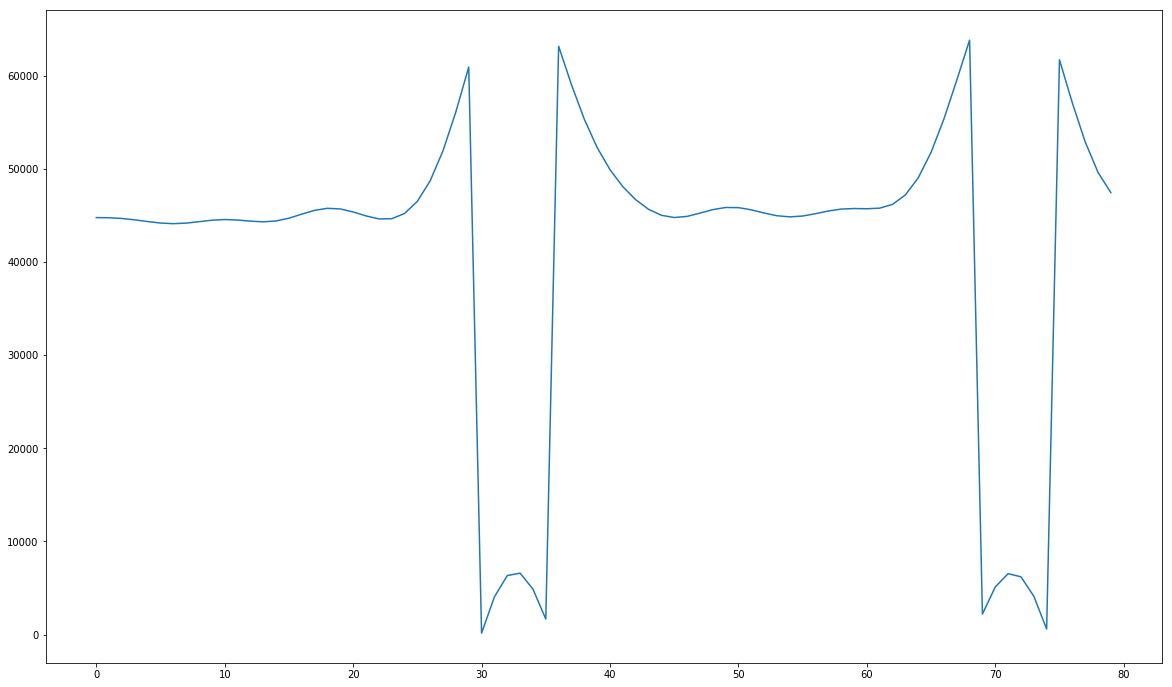

In [93]:
l1 = 153
#plt.plot(lines[(l1 * 910):(l1 * 910) + 80])
l2 = 154
#plt.plot(lines[(l2 * 910):(l2 * 910) + 80])
plt.plot(lines[(l1 * 910):(l1 * 910) + 80] + lines[(l2 * 910):(l2 * 910) + 80])

41.9190465544
(230230,)
uint8 (253, 910) (253, 910)


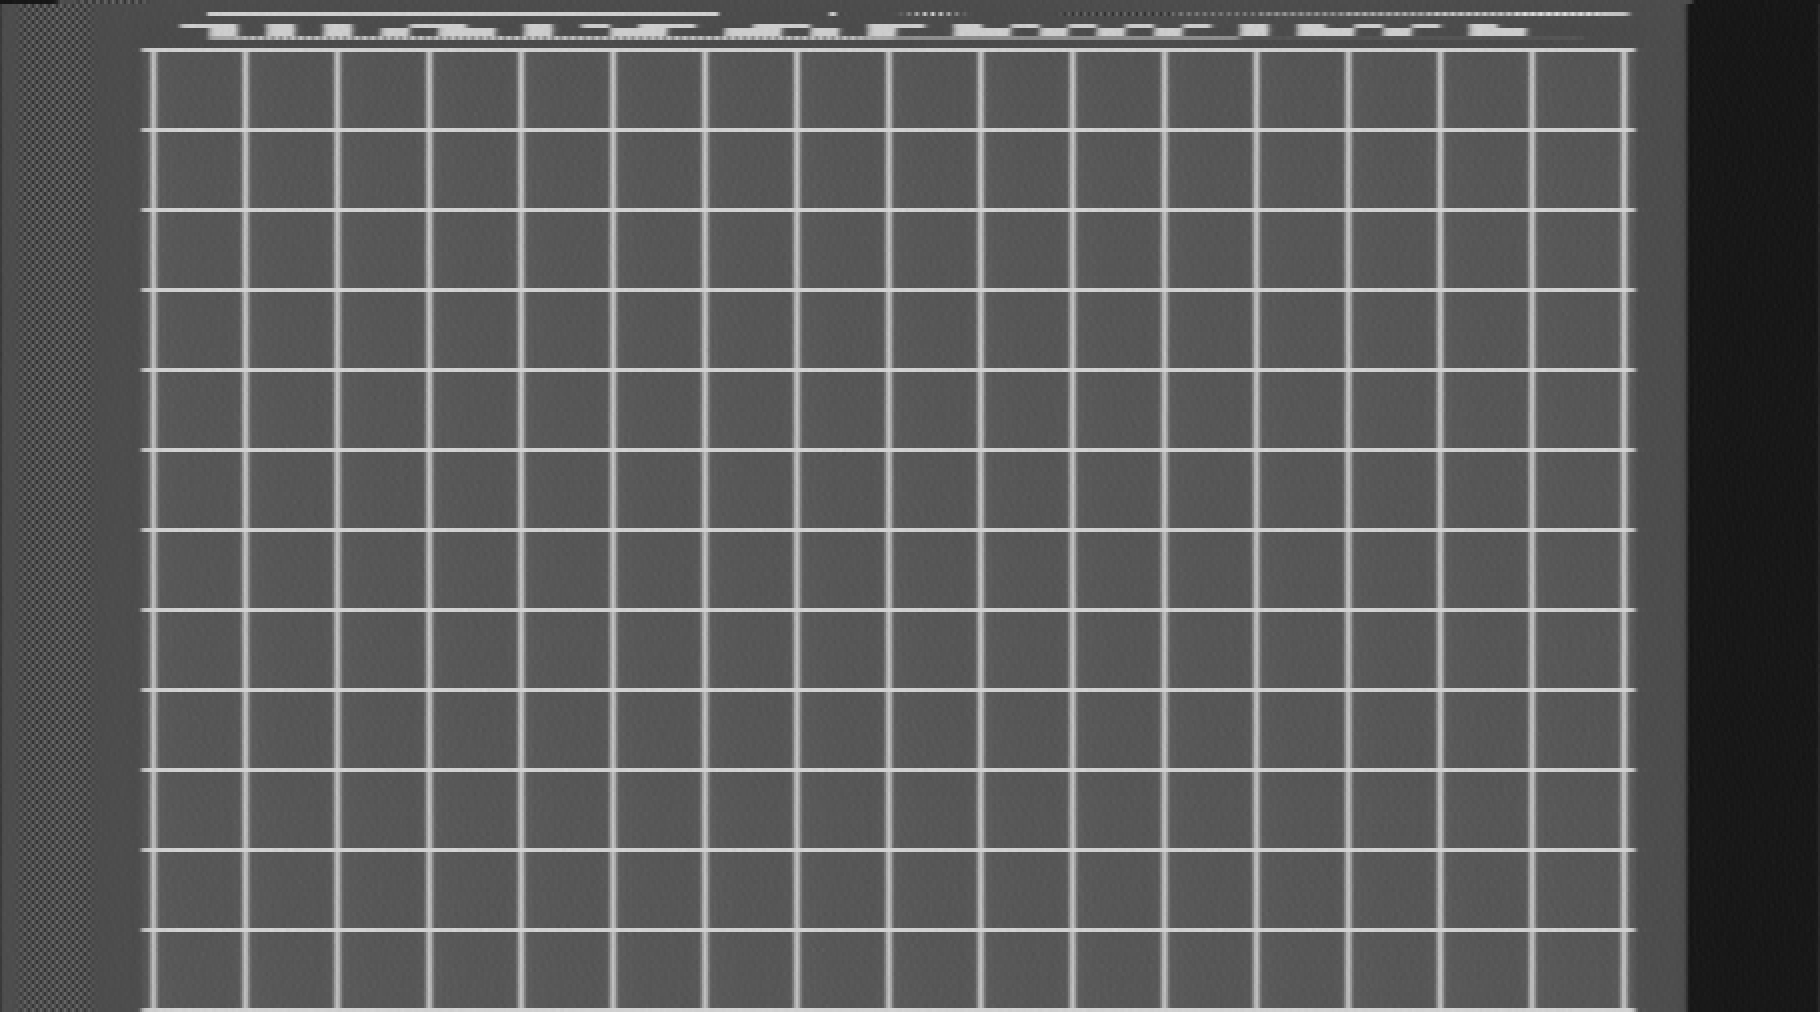

In [94]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

15.223902064847156

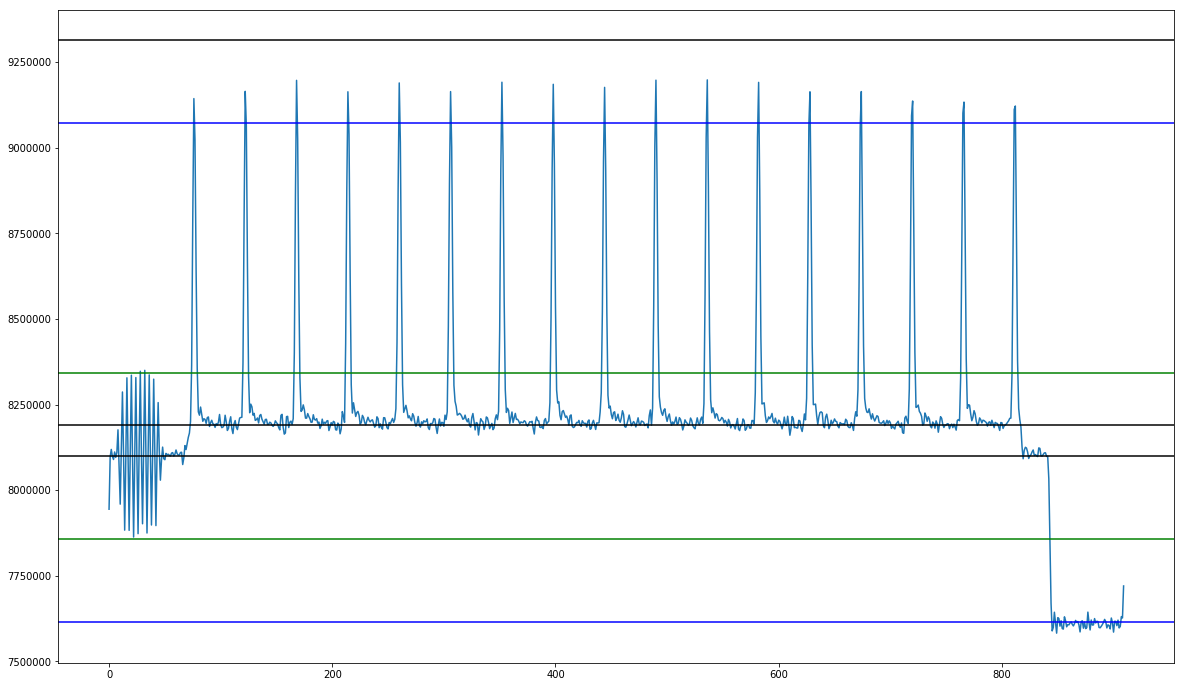

In [95]:
l = 100
x = lines[(910*l)+0:(910*l)+910]
lineplot(x, filterset)
calcsnr(x[180:700])

42.402933869795305

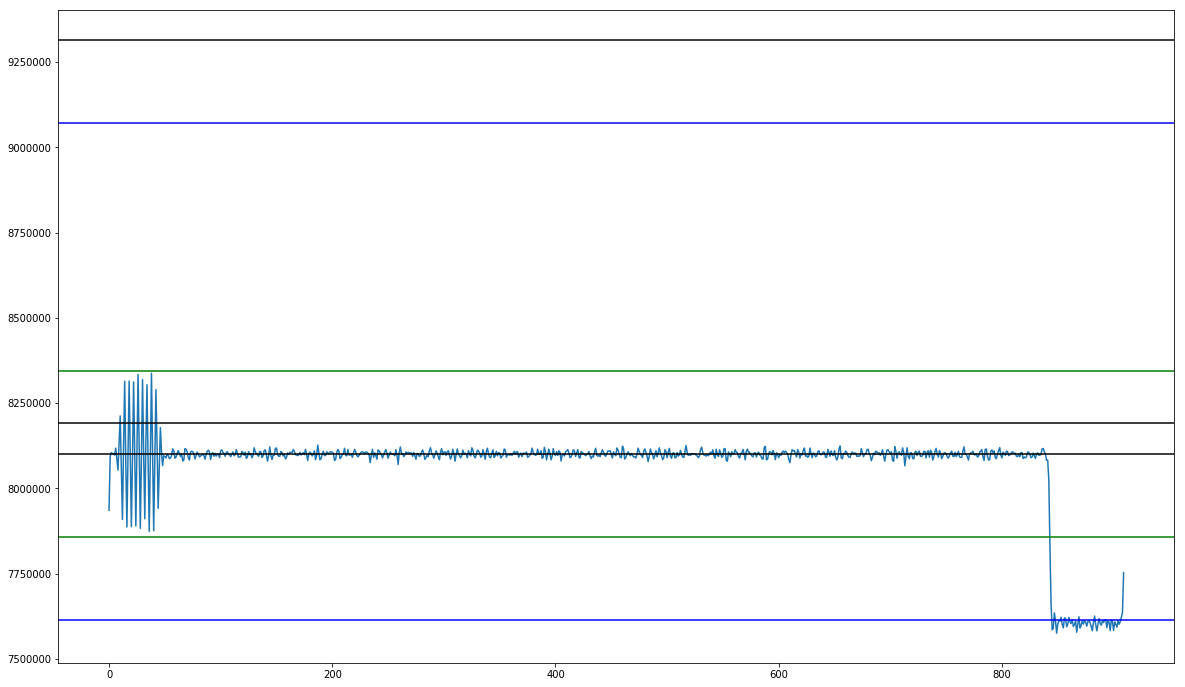

In [96]:
l = 1
x = lines[(910*l)+0:(910*l)+910]
lineplot(x, filterset)
calcsnr(x[180:700])

40.393861143793046

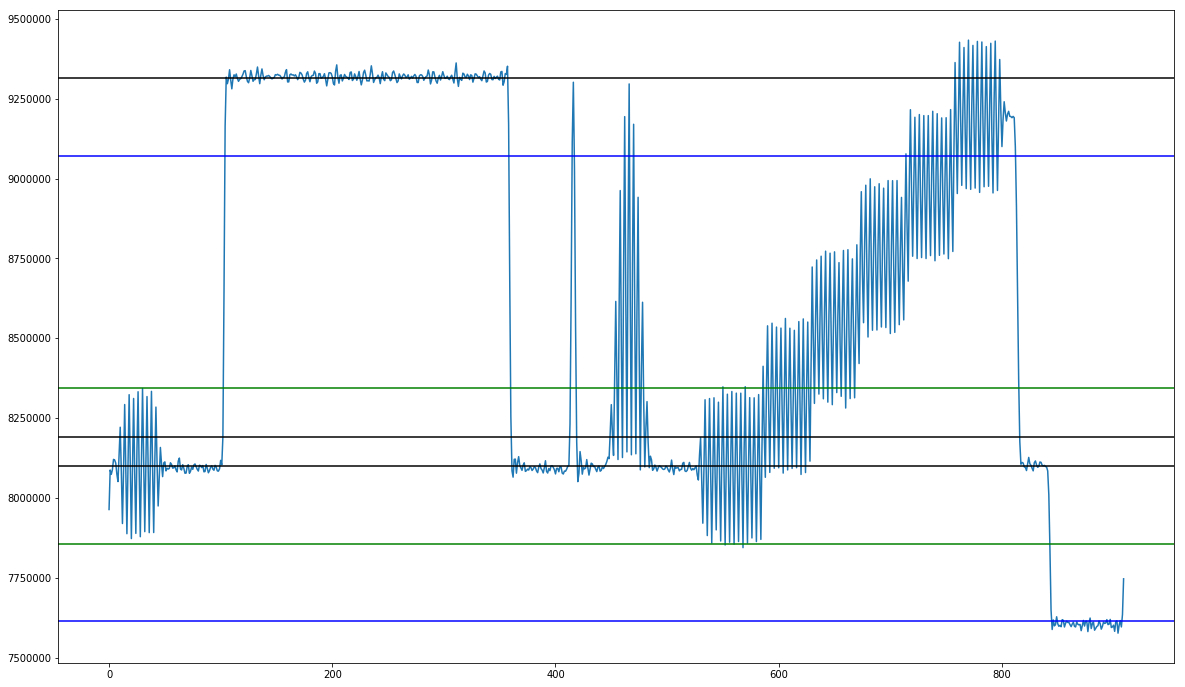

In [97]:
l = 3
x = lines[(910*l)+0:(910*l)+910]
lineplot(x, filterset)
calcsnr(x[150:350])

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

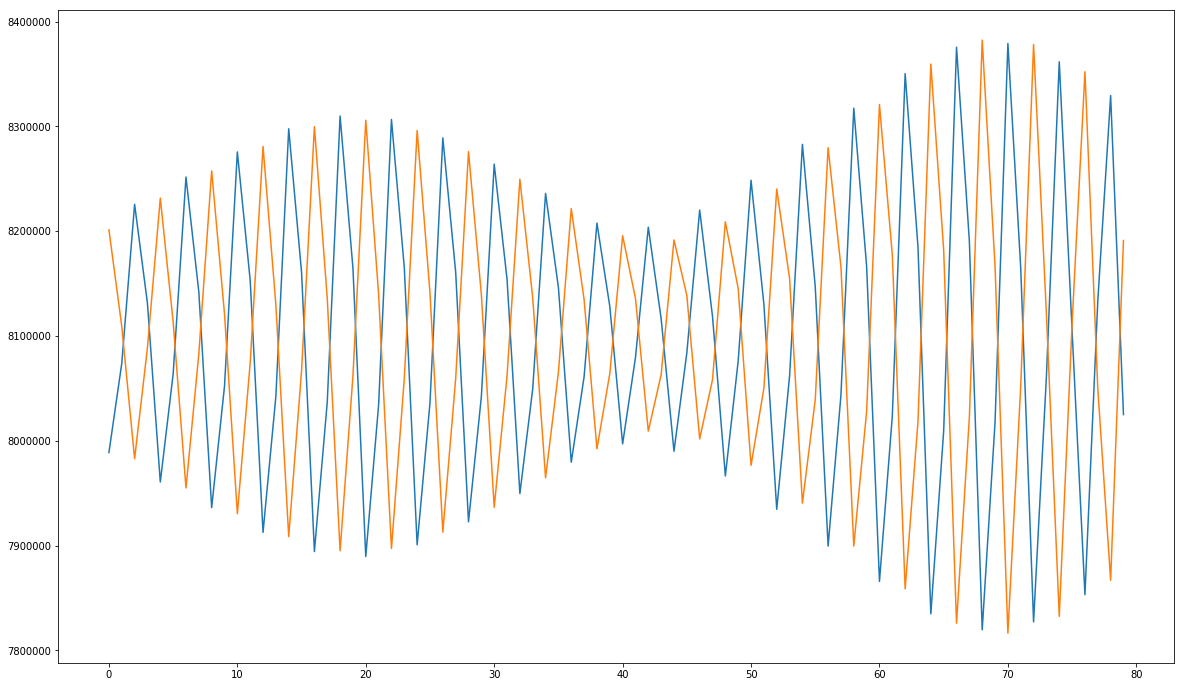

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

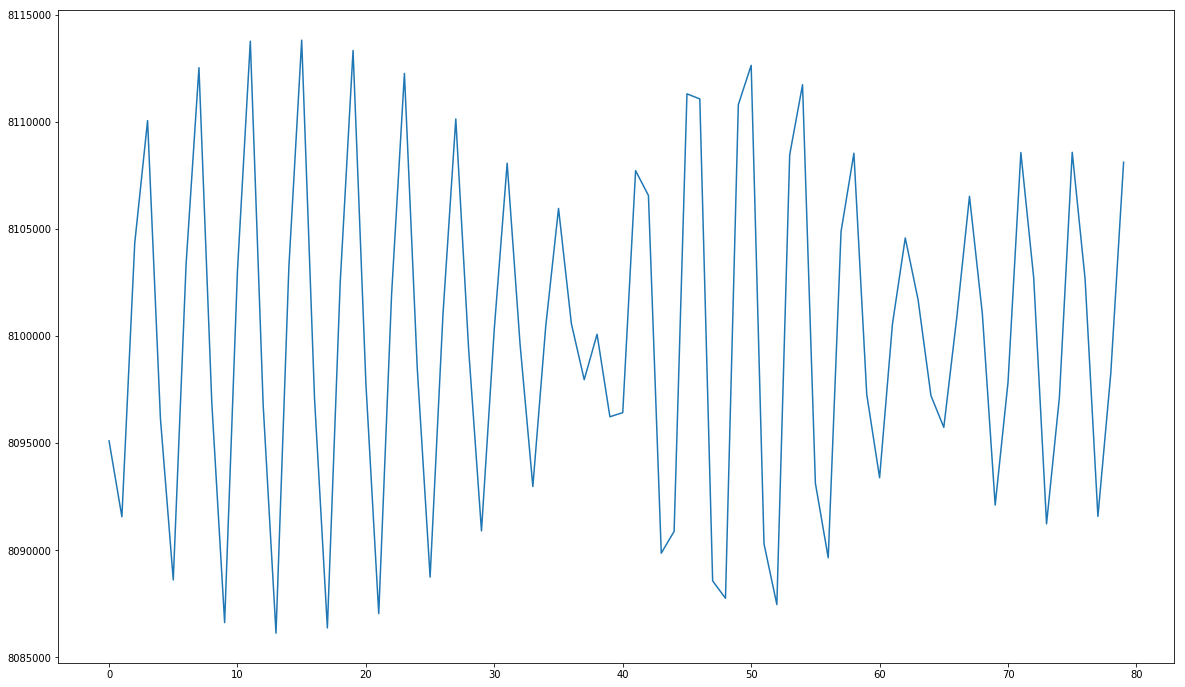

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


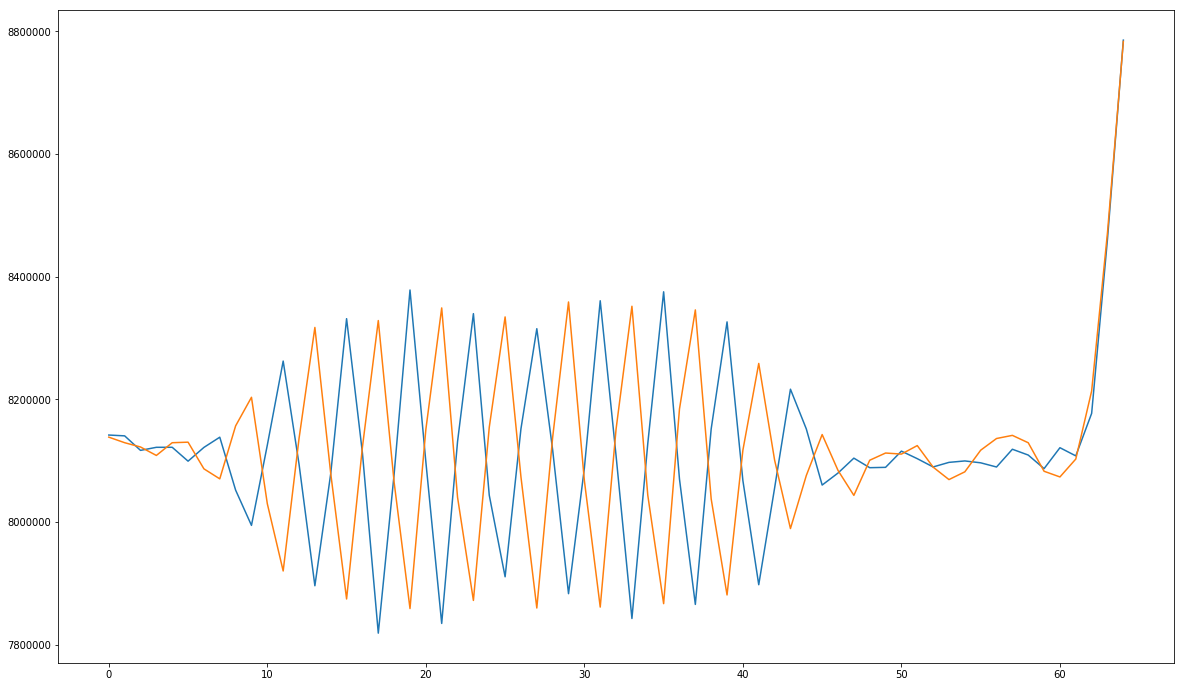

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


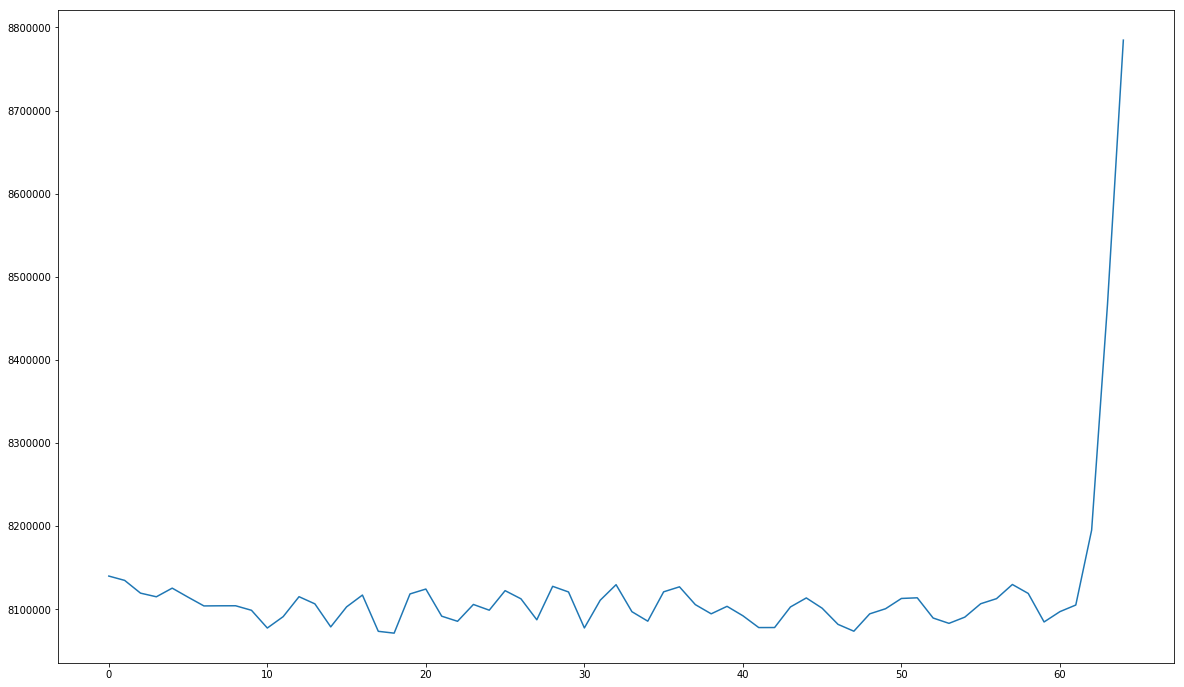

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


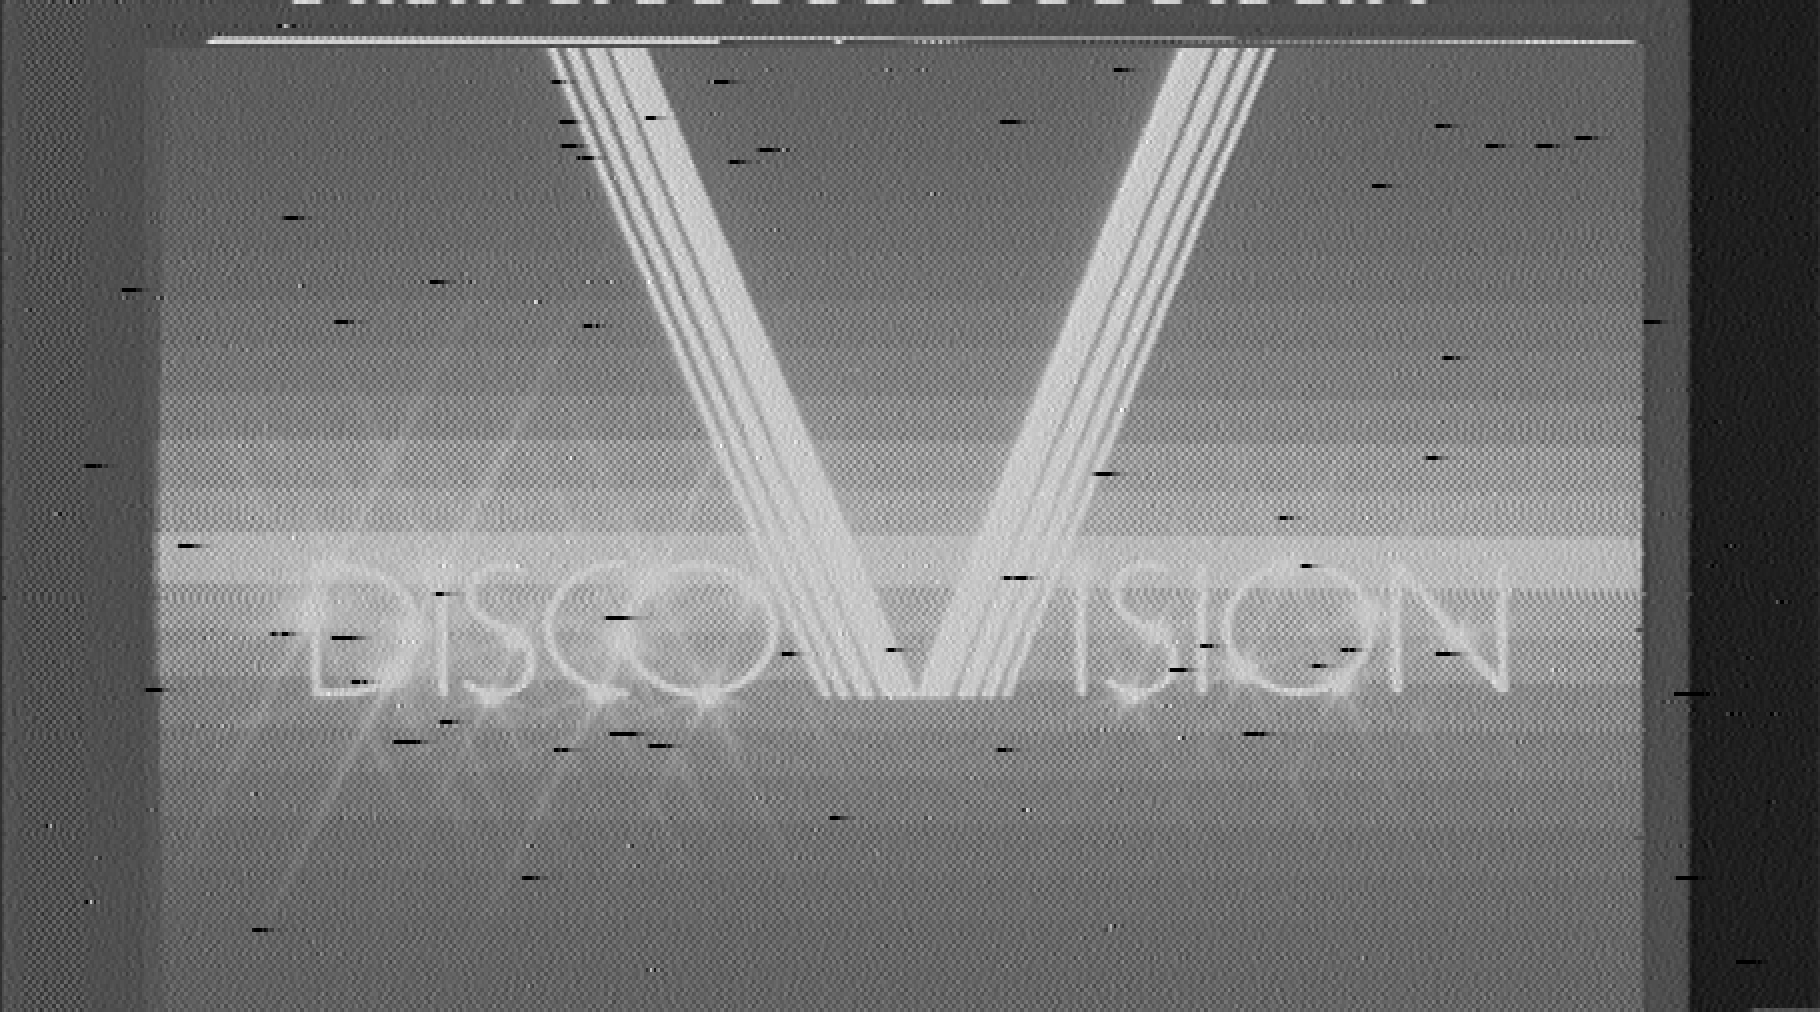

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

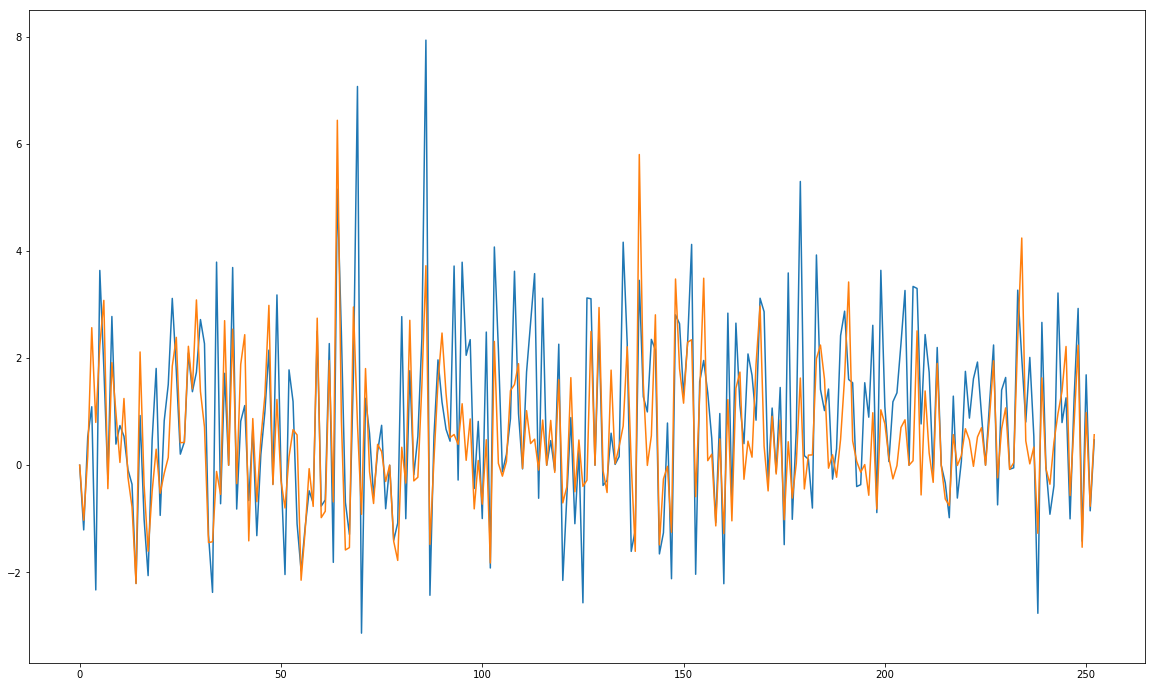

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

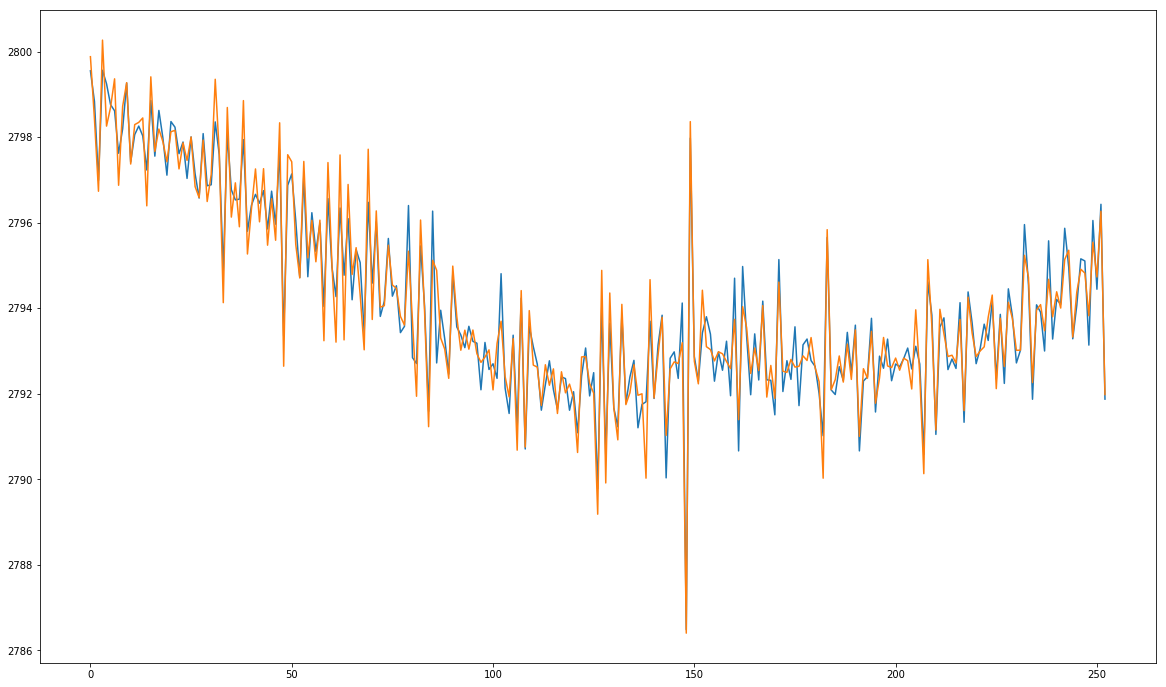

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))